In [ ]:
# !pip install -U transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [ ]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [1]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader
from functools import partial

from utils import latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore, cifar10_labels, free_memory, mnist_labels

seed = 42
set_seed(seed)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
    print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def load_data(repo_name, col_latent = "latent", col_label = "label"):
    print(f"loading dataset {repo_name}")
    
    ds = load_dataset(repo_name)
    splits = [k for k in ds]
    latent_shape = torch.Tensor(ds[splits[0]][0][col_latent]).shape
    features = ds[splits[0]].features

    assert len(splits)==2
    assert len(latent_shape)==4
    assert col_latent in features and col_label in features

    for i, split in enumerate(splits): print(f"split #{i} {split}: {len(ds[split])} samples, features: {[k for k in ds[split].features]}")
    print(f"latent shape {latent_shape}")

    return ds, splits, latent_shape

def collate_(items, labels_encoded, col_latent = "latent", col_label = "label"):
    assert col_latent in items[0] and col_label in items[0]
    labels = [i[col_label] for i in items]
    latents = torch.cat([torch.Tensor(i[col_latent]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

def get_dataloaders(ds, splits, bs):
    batch_sizes = [bs, bs//2]    # reduce eval_batch size
    dataloaders = []
    for i, split in enumerate(splits):
        batch_size = batch_sizes[i]
        print(f"Assuming split #{i} \"{split}\" is {'train' if i==0 else 'test'} split, testing batch size {batch_size}")
        dataloader = DataLoader(ds[split], batch_size=batch_size, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
        b = next(iter(dataloader))
        for i, col in enumerate(b):
            coltype = type(col)
            collength = len(col) if coltype==list else col.shape
            print(f" col {i} {coltype.__name__} {collength}")
        dataloaders.append(dataloader)
    return dataloaders

def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps

def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=42):
    assert latent_dim is not None
    dt, timesteps = get_timesteps(num_steps)
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent / dcae_scalingf, dcae)

def eval_clipscore(images, labels):
    prompts = [labels[k] for k in labels]
    return pil_clipscore(images, prompts)

def add_random_noise(latents, timesteps=1000):
    noise = torch.randn_like(latents)
    t = torch.randint(1, timesteps + 1, (latents.size(0),)).to(device)
    tperc = t.view([latents.size(0), *([1] * len(latents.shape[1:]))])/timesteps
    latents_noisy = (1 - tperc) * latents + tperc * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy, noise, t

def eval_loss(dataloader_eval, timesteps=1000, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, timesteps)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [7]:
for k in labels: print(f"{k}: {labels[k]}")

NameError: name 'labels' is not defined

Transformer parameters: 53.18M
DCAE parameters: 312.25M
loading dataset g-ronimo/CIFAR10-128-latents_dc-ae-f32c32-sana-1.0
split #0 train: 50000 samples, features: ['label', 'latent']
split #1 test: 10000 samples, features: ['label', 'latent']
latent shape torch.Size([1, 32, 4, 4])
Assuming split #0 "train" is train split, testing batch size 4
 col 0 list 4
 col 1 Tensor torch.Size([4, 32, 4, 4])
 col 2 Tensor torch.Size([4, 300, 768])
 col 3 Tensor torch.Size([4, 300])
Assuming split #1 "test" is test split, testing batch size 2
 col 0 list 2
 col 1 Tensor torch.Size([2, 32, 4, 4])
 col 2 Tensor torch.Size([2, 300, 768])
 col 3 Tensor torch.Size([2, 300])
Labels:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
Inspecting first batch
[9, 5, 1, 0] ['truck', 'dog', 'automobile', 'airplane']


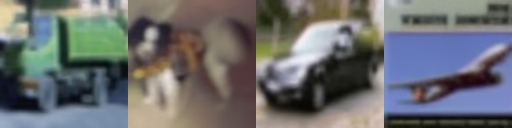

Testing generate


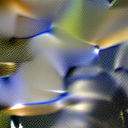

Testing eval loss


eval_loss: 0it [00:00, ?it/s]


2.40625
Testing eval images and clip score


eval_images: 100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]


21.77733612060547
steps per epoch: 12500


In [15]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
log_wandb = False
lr = 5e-4
bs = 4
epochs = 1000
timesteps_training = 1000
steps_log, steps_eval = 10, 100
# steps_log, steps_eval = 10, 20
wandb_project = "Hana-trainer-tests"

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = "answerdotai/ModernBERT-base",
    transformer_config = "transformer_Sana-7L-MBERT_config.json",
    # transformer_config = "transformer_Sana-xsmall.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
    dtype = dtype,
    device = device
)

# ds, ds_splits, latent_shape = load_data("g-ronimo/MNIST-latents_dc-ae-f32c32-sana-1.0")
ds, ds_splits, latent_shape = load_data("g-ronimo/CIFAR10-128-latents_dc-ae-f32c32-sana-1.0")

labels = cifar10_labels
eval_labels = labels
collate = partial(collate_, labels_encoded = {k: encode_prompt(str(k), tokenizer, text_encoder) for k in labels})
dataloader_train, dataloader_eval = get_dataloaders(ds, ds_splits, bs)

print("Labels:")
for k in labels: print(f"{k}: {labels[k]}")

print("Inspecting first batch")
def inspect_first_batch():
    labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
    print(labels, [eval_labels[l] for l in labels])
    display(make_grid(latent_to_PIL(latents, dcae)))
inspect_first_batch()

print("Testing generate")
display(generate("horse", tokenizer, text_encoder, num_steps=10, latent_dim=latent_shape).resize((128,128)))

print("Testing eval loss")
print(eval_loss(dataloader_eval, testing=True))

print("Testing eval images and clip score")
images = [
    generate(p, tokenizer, text_encoder, latent_dim=latent_shape, num_steps=10) 
    for p in tqdm([labels[k] for k in labels], "eval_images")
]
print(eval_clipscore(images, labels))

steps_epoch = len(dataloader_train)
print(f"steps per epoch: {steps_epoch}")

optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)

model_size = sum(p.numel() for p in transformer.parameters())
wandb_run = f"{model_size / 1e6:.2f}M_MNIST_LR-{lr}_BS-{bs}_TS-{timesteps_training}_my3090"

del labels

# Train

In [16]:
if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project=wandb_project, name=wandb_run).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()

for _ in range(epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents)
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if step>0 and step % steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * bs, "epoch": step / steps_epoch})
            last_step_time = time.time()
    
        if step>0 and step % steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)
            images_eval = [generate(p, tokenizer, text_encoder, latent_dim=latent_shape) for p in tqdm([eval_labels[k] for k in eval_labels], "eval_images")]
            clipscore = eval_clipscore(images_eval, eval_labels)
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(make_grid(images_eval, 2, 5)), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            transformer.train()
        step += 1

step 10, epoch: 0.0008, train loss: 1.8047, grad_norm: 5.41, 212.33ms/step, 18.84samples/sec
step 20, epoch: 0.0016, train loss: 1.9531, grad_norm: 4.84, 85.04ms/step, 47.04samples/sec
step 30, epoch: 0.0024, train loss: 2.0625, grad_norm: 5.78, 84.88ms/step, 47.13samples/sec
step 40, epoch: 0.0032, train loss: 1.9609, grad_norm: 4.66, 84.54ms/step, 47.32samples/sec
step 50, epoch: 0.0040, train loss: 1.7656, grad_norm: 3.56, 84.59ms/step, 47.29samples/sec
step 60, epoch: 0.0048, train loss: 1.8047, grad_norm: 3.97, 85.71ms/step, 46.67samples/sec
step 70, epoch: 0.0056, train loss: 1.9531, grad_norm: 3.06, 85.60ms/step, 46.73samples/sec
step 80, epoch: 0.0064, train loss: 1.7344, grad_norm: 2.56, 86.11ms/step, 46.45samples/sec
step 90, epoch: 0.0072, train loss: 1.8125, grad_norm: 3.19, 85.23ms/step, 46.93samples/sec
step 100, epoch: 0.0080, train loss: 1.8359, grad_norm: 3.16, 84.74ms/step, 47.20samples/sec


eval_loss: 396it [00:06, 63.07it/s]


KeyboardInterrupt: 

In [ ]:
# transformer.push_to_hub(f"g-ronimo/hana-alpha14_cifar10-128_TS-{timesteps_training}_{epochs}e")

In [ ]:
# !runpodctl remove pod $RUNPOD_POD_ID